In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (16, 10)

<IPython.core.display.Javascript object>

----------------------------------------

## Read Data

In [8]:
trips = pd.read_csv("../data/trips/daily_trips.csv")
trips.date = pd.to_datetime(trips.date)
trips.rename(columns={"date": "ds", "daily_trips": "y"}, inplace=True)
trips.sort_values("ds", inplace=True)

weather = pd.read_csv("../data/weather/daily_weather.csv")
weather.date = pd.to_datetime(weather.date)
weather.rename(
    columns={
        "date": "ds",
        "Normal_Max_Temp_C": "tmax",
        "Normal_Min_Temp_C": "tmin",
        "Normal_Precipitation_CM": "precip",
    },
    inplace=True,
)

trips = pd.merge(trips, weather, on="ds", how="left")

holidays = pd.read_csv("../data/holidays/holidays.csv")
holidays.ds = pd.to_datetime(holidays.ds)

<IPython.core.display.Javascript object>

-------------------

## Bike Rental Forecaster

In [27]:
def get_predict_range(predict_beg_d, horizon, freq):
    predict_beg_d = pd.to_datetime(predict_beg_d)
    end_range = predict_beg_d + pd.Timedelta(horizon - 1, freq)
    return (predict_beg_d, end_range)

<IPython.core.display.Javascript object>

In [26]:
get_predict_range("2016-01-01", 14, "D")

Timestamp('2016-01-14 00:00:00')

<IPython.core.display.Javascript object>

In [28]:
def train_and_predict(
    trips, holidays, predict_beg_d, horizon, freq, train_beg_d=None, train_end_d=None
):
    predict_beg_d, predict_end_d = get_predict_range(predict_beg_d, horizon, freq)

    if train_beg_d is None:
        train_beg_d = trips.ds.min()
    if train_end_d is None:
        train_end_d = pd.to_datetime(predict_beg_d) + pd.Timedelta(-1, "D")

    train = trips[(trips.ds >= train_beg_d) & (trips.ds <= train_end_d)].copy()
    test = trips[(trips.ds >= predict_beg_d) & (trips.ds <= predict_end_d)].copy()

    mod = Prophet(holidays=holidays, seasonality_mode="multiplicative")
    mod.add_regressor("tmax")
    mod.add_regressor("precip")
    # mod.add_regressor('tmin') # don't add tmin as it is too correlated with tmax
    mod.fit(train)
    forecast = mod.predict(test)[["ds", "yhat"]]

    return forecast

<IPython.core.display.Javascript object>

In [41]:
start_dates = pd.date_range("2016-01-01", "2017-12-18", freq="W")
forecast_list = []

for sd in start_dates:
    forecast = train_and_predict(trips, holidays, sd, 7, "D")
    forecast["version"] = sd
    forecast["horizon"] = forecast.ds - forecast["version"]
    forecast_list.append(forecast)


17:19:52 - cmdstanpy - INFO - Chain [1] start processing
17:19:53 - cmdstanpy - INFO - Chain [1] done processing
17:19:53 - cmdstanpy - INFO - Chain [1] start processing
17:19:53 - cmdstanpy - INFO - Chain [1] done processing
17:19:54 - cmdstanpy - INFO - Chain [1] start processing
17:19:54 - cmdstanpy - INFO - Chain [1] done processing
17:19:54 - cmdstanpy - INFO - Chain [1] start processing
17:19:54 - cmdstanpy - INFO - Chain [1] done processing
17:19:55 - cmdstanpy - INFO - Chain [1] start processing
17:19:55 - cmdstanpy - INFO - Chain [1] done processing
17:19:56 - cmdstanpy - INFO - Chain [1] start processing
17:19:56 - cmdstanpy - INFO - Chain [1] done processing
17:19:56 - cmdstanpy - INFO - Chain [1] start processing
17:19:56 - cmdstanpy - INFO - Chain [1] done processing
17:19:57 - cmdstanpy - INFO - Chain [1] start processing
17:19:57 - cmdstanpy - INFO - Chain [1] done processing
17:19:57 - cmdstanpy - INFO - Chain [1] start processing
17:19:58 - cmdstanpy - INFO - Chain [1]

17:20:38 - cmdstanpy - INFO - Chain [1] done processing
17:20:39 - cmdstanpy - INFO - Chain [1] start processing
17:20:39 - cmdstanpy - INFO - Chain [1] done processing
17:20:39 - cmdstanpy - INFO - Chain [1] start processing
17:20:39 - cmdstanpy - INFO - Chain [1] done processing
17:20:40 - cmdstanpy - INFO - Chain [1] start processing
17:20:40 - cmdstanpy - INFO - Chain [1] done processing
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] done processing
17:20:43 - cmdstanpy - INFO - Chain [1] start processing
17:20:43 - cmdstanpy - INFO - Chain [1] done processing
17:20:43 - cmdstanpy - INFO - Chain [1] start processing
17:20:44 - cmdstanpy - INFO - Chain [1] done processing
17:20:44 - cmdstanpy - INFO - Chain [1] 

<IPython.core.display.Javascript object>

In [43]:
results = pd.concat(forecast_list)

<IPython.core.display.Javascript object>

In [45]:
results = results.merge(trips[["ds", "y"]], how="left", on="ds")

<IPython.core.display.Javascript object>

In [55]:
mape(results["y"], results["yhat"])

0.271068274130998

<IPython.core.display.Javascript object>

In [49]:
results.groupby("horizon").apply(lambda row: mape(row["y"], row["yhat"]))

horizon
0 days    0.276680
1 days    0.282076
2 days    0.238251
3 days    0.269285
4 days    0.220925
5 days    0.225595
6 days    0.385621
dtype: float64

<IPython.core.display.Javascript object>

In [54]:
results.groupby("version").apply(lambda row: mape(row["y"], row["yhat"]))

version
2016-01-03    0.220897
2016-01-10    0.189315
2016-01-17    0.638106
2016-01-24    3.340876
2016-01-31    0.160015
                ...   
2017-11-19    0.125861
2017-11-26    0.194862
2017-12-03    0.370322
2017-12-10    0.244271
2017-12-17    0.347769
Length: 103, dtype: float64

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Density'>

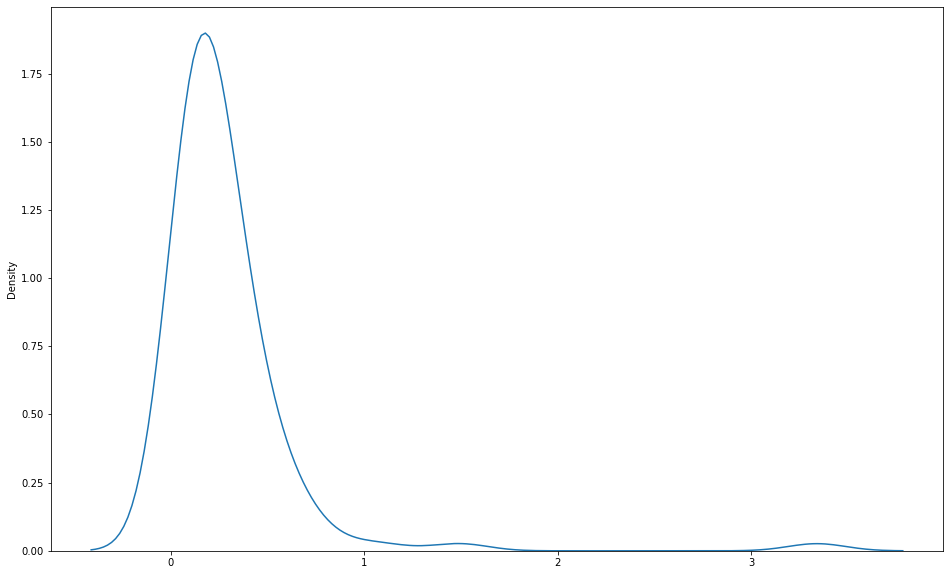

<IPython.core.display.Javascript object>

In [53]:
sns.kdeplot(results.groupby("version").apply(lambda row: mape(row["y"], row["yhat"])))